# Two Moons Diffusion

First we start by generating a two moons distribution and visualizing it using matplotlib.

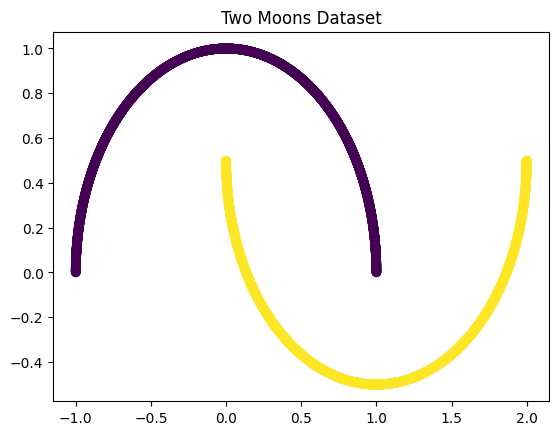

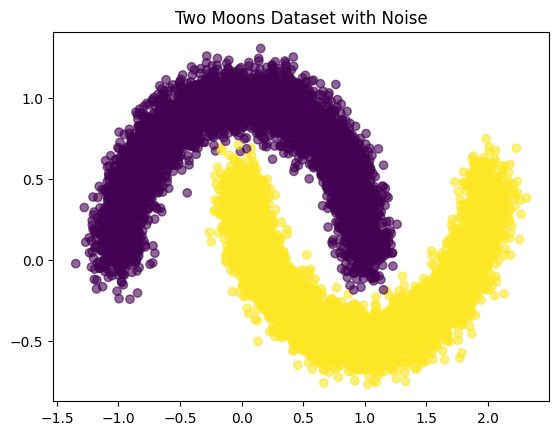

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import torch
import numpy as np


def visualize_moons(dataset, title="Two Moons Dataset"):
    coords, labels = dataset
    plt.scatter(coords[:, 0], coords[:, 1], c=labels, alpha=0.6)
    plt.title(title)
    plt.show()


random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
torch.set_default_device("cuda")

moons_dataset_unnoised = make_moons(n_samples=10000, random_state=random_seed)
visualize_moons(moons_dataset_unnoised)

moons_dataset_noised = make_moons(n_samples=10000, noise=0.1, random_state=random_seed)
visualize_moons(moons_dataset_noised, title="Two Moons Dataset with Noise")

We implement diffusion with DDPM formulation and DDIM sampling that is a deterministic Euler method.

For the noise predictor network we use a very simple architecture, consisting of a time embedder and a small MLP to predict the noise from the samples and the time embedding.  We can improve the architecture later if needed.

In [2]:
import torch
import torch.nn as nn


class NoisePredictor(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128, time_embed_dim=32):
        super().__init__()
        self.time_embed_dim = time_embed_dim

        self.time_embed = nn.Sequential(
            nn.Linear(1, time_embed_dim),
            nn.ReLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        self.net = nn.Sequential(
            nn.Linear(input_dim + time_embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x, t):
        t_embed = self.time_embed(t)
        x = torch.cat([x, t_embed], dim=-1)
        return self.net(x)

In [3]:
import torch.nn.functional as F
from tqdm.auto import tqdm


class DiffusionModel:
    def __init__(
        self, model, num_timesteps=1000, beta_start=1e-4, beta_end=0.02, device="cuda"
    ):
        self.num_timesteps = num_timesteps
        self.device = device
        self.model = model.to(device)

        self.betas = torch.linspace(beta_start, beta_end, num_timesteps).to(device)
        self.alphas = 1.0 - self.betas
        self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)

        self.sqrt_alpha_cumprod = torch.sqrt(self.alpha_cumprod)
        self.sqrt_one_minus_alpha_cumprod = torch.sqrt(1.0 - self.alpha_cumprod)

    def ddim_sample_step(self, x_t, t, t_prev):
        predicted_noise = self.model(x_t, t.float().unsqueeze(-1))

        alpha_cumprod_t = self.alpha_cumprod[t].reshape(-1, 1)
        alpha_cumprod_t_prev = (
            self.alpha_cumprod[t_prev].reshape(-1, 1)
            if t_prev >= 0
            else torch.ones_like(alpha_cumprod_t)
        )

        sqrt_alpha_cumprod_t = torch.sqrt(alpha_cumprod_t)
        sqrt_one_minus_alpha_cumprod_t = torch.sqrt(1.0 - alpha_cumprod_t)
        pred_x0 = (
            x_t - sqrt_one_minus_alpha_cumprod_t * predicted_noise
        ) / sqrt_alpha_cumprod_t

        sqrt_alpha_cumprod_t_prev = torch.sqrt(alpha_cumprod_t_prev)
        sqrt_one_minus_alpha_cumprod_t_prev = torch.sqrt(1.0 - alpha_cumprod_t_prev)

        dir_xt = sqrt_one_minus_alpha_cumprod_t_prev * predicted_noise

        x_prev = sqrt_alpha_cumprod_t_prev * pred_x0 + dir_xt

        return x_prev

    def sample(self, num_samples, num_inference_steps=50, shape=(2,)):
        self.model.eval()

        step_size = self.num_timesteps // num_inference_steps
        timesteps = torch.arange(0, self.num_timesteps, step_size).long()
        timesteps = torch.cat([timesteps, torch.tensor([self.num_timesteps - 1])])
        timesteps = torch.flip(timesteps, [0])

        x = torch.randn(num_samples, *shape).to(self.device)

        for i, t in enumerate(tqdm(timesteps[:-1], desc="Sampling")):
            t_prev = timesteps[i + 1] if i < len(timesteps) - 2 else -1

            t_batch = torch.full((num_samples,), t, dtype=torch.long).to(self.device)

            with torch.no_grad():
                x = self.ddim_sample_step(x, t_batch, t_prev)

        return x

    def q_sample(self, x0, t, noise=None):
        sqrt_alpha_cumprod_t = self.sqrt_alpha_cumprod[t].reshape(-1, 1)
        sqrt_one_minus_alpha_cumprod_t = self.sqrt_one_minus_alpha_cumprod[t].reshape(
            -1, 1
        )

        return sqrt_alpha_cumprod_t * x0 + sqrt_one_minus_alpha_cumprod_t * noise, noise

    def train_step(self, x0):
        batch_size = x0.shape[0]

        t = torch.randint(0, self.num_timesteps, (batch_size,)).to(self.device)
        noise = torch.randn_like(x0)

        x_t, _ = self.q_sample(x0, t, noise)

        predicted_noise = self.model(x_t, t.float().unsqueeze(-1))

        loss = F.mse_loss(predicted_noise, noise)

        return loss

Here is the trainer class used to train our diffusion model.

In [4]:
class Trainer:
    def __init__(
        self,
        model,
        device="cuda",
        num_epochs=10,
        batch_size=64,
        num_batches_per_epoch=10,
        learning_rate=1e-4,
        num_train_samples=20_000,
    ):
        self.device = device
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.num_batches_per_epoch = num_batches_per_epoch
        self.learning_rate = learning_rate
        self.num_train_samples = num_train_samples

        self.diffusion = DiffusionModel(model, device=device)
        self.optimizer = torch.optim.Adam(
            self.diffusion.model.parameters(), lr=learning_rate
        )

        self.train_dataset = torch.tensor(
            make_moons(n_samples=num_train_samples, noise=0.1, random_state=42)[0],
            dtype=torch.float32,
        )

    def train(self):
        self.diffusion.model.train()

        losses = []

        for _ in tqdm(range(self.num_epochs), desc="Training"):
            for _ in range(self.num_batches_per_epoch):
                indices = torch.randperm(len(self.train_dataset))[: self.batch_size]
                batch = self.train_dataset[indices].to(self.device)

                self.optimizer.zero_grad()

                loss = self.diffusion.train_step(batch)
                loss.backward()
                self.optimizer.step()

            losses.append(loss.item())

        return losses

    def make_loss_curve(self, losses):
        plt.plot(losses)
        plt.xlabel("Training Steps")
        plt.ylabel("Loss")
        plt.title("Loss Curve")
        plt.grid()
        plt.show()

Now let's train our first model for 500 epochs and see what the results look like.

Training:   0%|          | 0/500 [00:00<?, ?it/s]

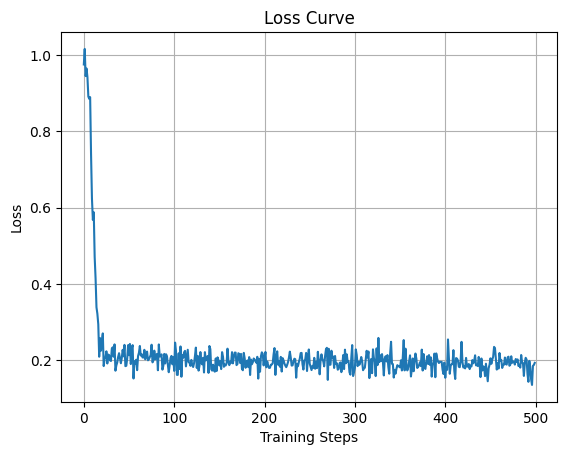

In [5]:
trainer = Trainer(
    model=NoisePredictor(),
    num_epochs=500,
    batch_size=512,
    num_batches_per_epoch=100,
    learning_rate=1e-4,
)
losses = trainer.train()
trainer.make_loss_curve(losses)

In [6]:
class Evaluator:
    def __init__(self, trainer, num_samples=100):
        self.trainer = trainer
        self.diffusion = trainer.diffusion

        self.num_samples = num_samples

    def eval(self):
        with torch.no_grad():
            samples = self.diffusion.sample(self.num_samples).cpu()

        self._visualize(samples)

    def _visualize(self, samples):
        gt = self.trainer.train_dataset.clone().cpu()

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.title("Generated Samples")
        plt.scatter(samples[:, 0], samples[:, 1], s=5)
        plt.axis("equal")

        plt.subplot(1, 2, 2)
        plt.title("Ground Truth")
        plt.scatter(gt[:, 0], gt[:, 1], s=5)
        plt.axis("equal")

        plt.show()

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

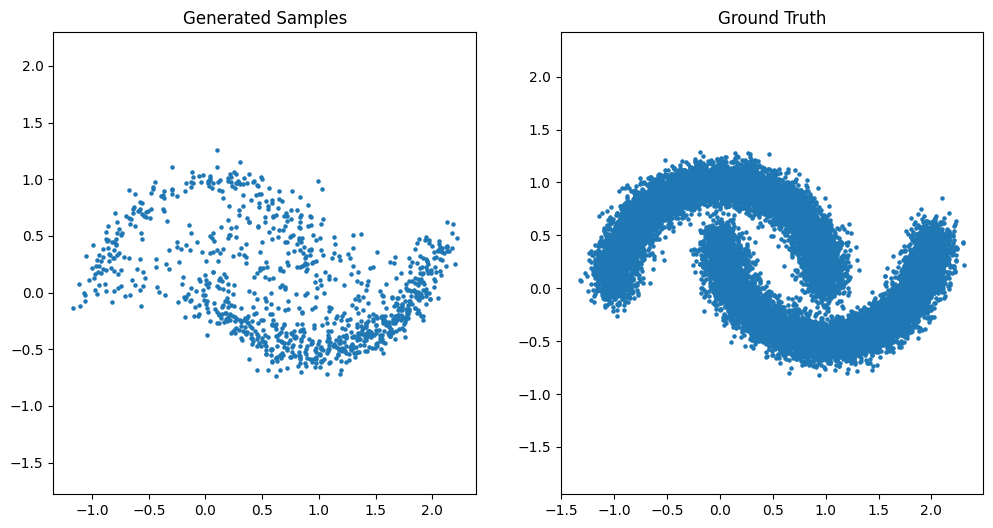

In [7]:
ev = Evaluator(trainer, num_samples=1000)
ev.eval()

Results look pretty good for a start!

Now let's see if we get better results by training for longer...

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

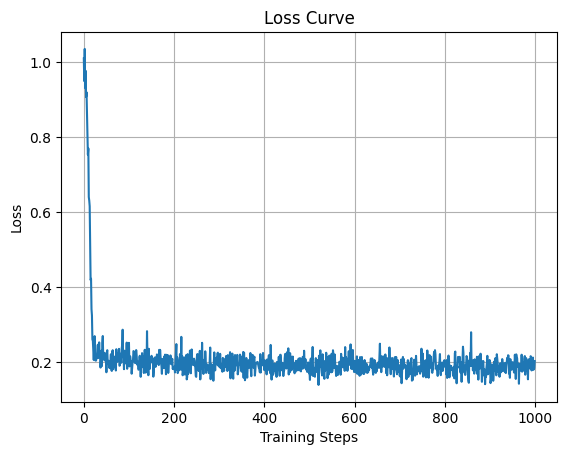

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

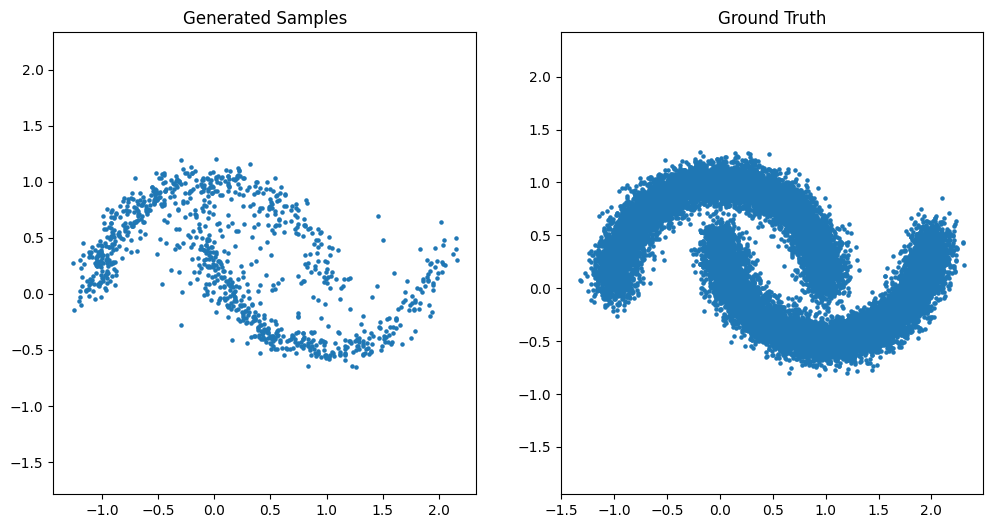

In [9]:
trainer = Trainer(
    model=NoisePredictor(),
    num_epochs=1000,
    batch_size=512,
    num_batches_per_epoch=100,
    learning_rate=1e-4,
)
losses = trainer.train()
trainer.make_loss_curve(losses)

ev = Evaluator(trainer, num_samples=1000)
ev.eval()

Results are getting better, let's try to train even longer.

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

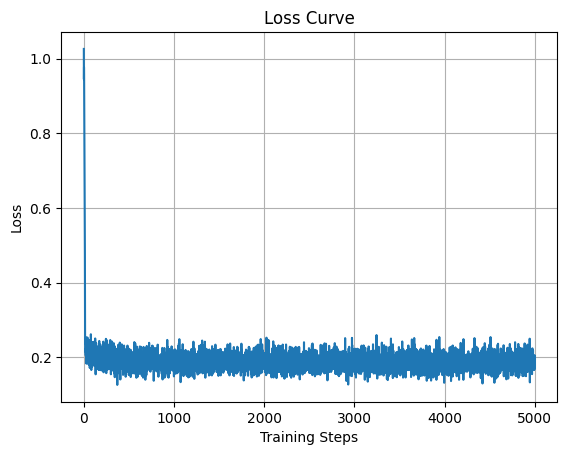

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

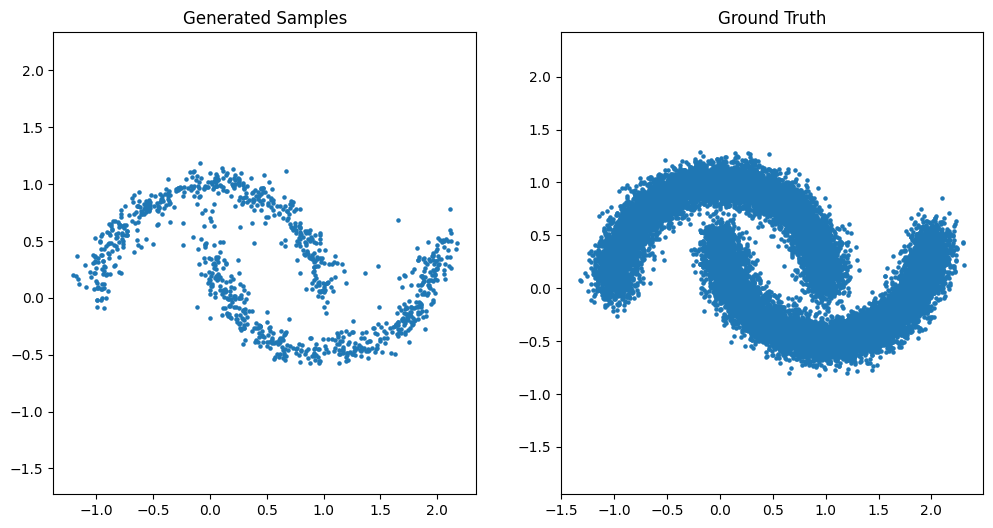

In [10]:
trainer = Trainer(
    model=NoisePredictor(),
    num_epochs=5_000,
    batch_size=512,
    num_batches_per_epoch=100,
    learning_rate=1e-4,
)
losses = trainer.train()
trainer.make_loss_curve(losses)

ev = Evaluator(trainer, num_samples=1000)
ev.eval()

Great! Now it's time to define some metrics.

The first metric we define is based on the distance of the generated samples to the real samples.  We use the kNN algorithm to find the nearest sample to each of the generated samples.  We select a cut-off radius of 0.2 and calculate how many of the generated samples fall within that radius of the real samples.  The higher this number the closer the distribution of generated samples should be to the two moons dataset.

In [ ]:
from sklearn.neighbors import NearestNeighbors


class Evaluator:
    def __init__(self, trainer, num_samples=100):
        self.trainer = trainer
        self.diffusion = trainer.diffusion

        self.num_samples = num_samples

    def eval(self):
        with torch.no_grad():
            samples = self.diffusion.sample(self.num_samples).cpu()

        self._visualize(samples)

        distance_metric = self.calculate_distance_metric(samples)
        print(f"Distance Metric: {distance_metric}")

    def calculate_distance_metric(self, generated_samples, radius=0.02):
        real_samples = trainer.train_dataset[: len(generated_samples)].clone().cpu()

        nn = NearestNeighbors(n_neighbors=1).fit(real_samples.numpy())
        distances, _ = nn.kneighbors(generated_samples.numpy())

        return (distances.flatten() < radius).astype(int).sum() / len(generated_samples)

    def _visualize(self, samples):
        gt = self.trainer.train_dataset.clone().cpu()

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.title("Generated Samples")
        plt.scatter(samples[:, 0], samples[:, 1], s=5)
        plt.axis("equal")

        plt.subplot(1, 2, 2)
        plt.title("Ground Truth")
        plt.scatter(gt[:, 0], gt[:, 1], s=5)
        plt.axis("equal")

        plt.show()

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

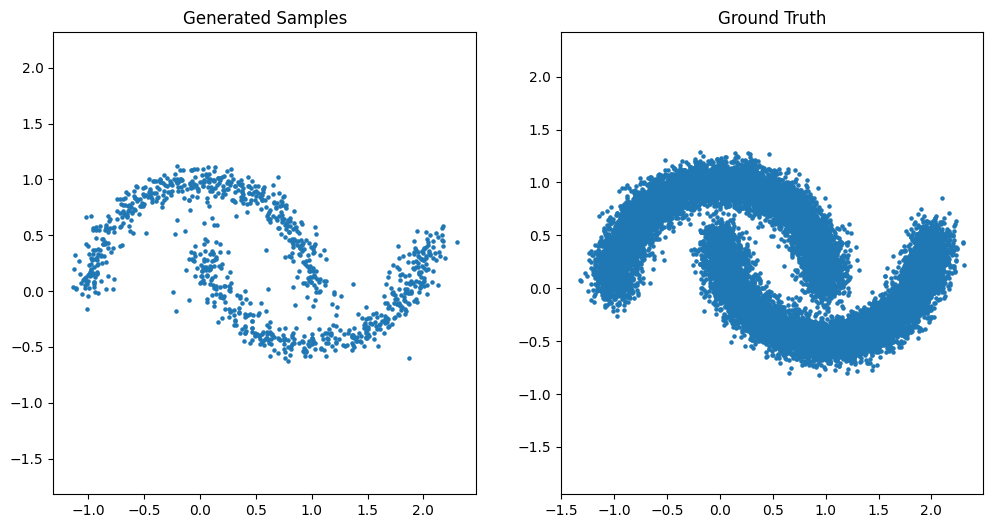

Distance Metric: 0.442


In [34]:
ev = Evaluator(trainer, num_samples=1000)
ev.eval()

Another metric could be an MSE between the generated and real samples.  We can't use an MSE directly because the order of the samples would matter, so instead we convert the real and generated samples into a normalized histogram, and calculate the MSE between the histograms.

Since with MSE lower values is better, we also reverse the distance metric so that we'd want to minimize both.

In [44]:
class Evaluator:
    def __init__(self, trainer, num_samples=100):
        self.trainer = trainer
        self.diffusion = trainer.diffusion

        self.num_samples = num_samples

    def eval(self):
        with torch.no_grad():
            samples = self.diffusion.sample(self.num_samples).cpu()

        self._visualize(samples)

        metrics = self.calculate_metrics(samples)
        print(f"Distance: {metrics['distance']:.4f}")
        print(f"MSE: {metrics['mse']:.4f}")

    def calculate_metrics(self, generated_samples):
        real_samples = trainer.train_dataset[: len(generated_samples)].clone().cpu()

        return {
            "distance": self.calculate_distance_metric(generated_samples, real_samples),
            "mse": self.calculate_mse_metric(generated_samples, real_samples),
        }

    def calculate_mse_metric(self, generated_samples, real_samples):
        all_samples = np.vstack([real_samples.numpy(), generated_samples.numpy()])
        x_min, x_max = all_samples[:, 0].min() - 0.5, all_samples[:, 0].max() + 0.5
        y_min, y_max = all_samples[:, 1].min() - 0.5, all_samples[:, 1].max() + 0.5
        bounds = [[x_min, x_max], [y_min, y_max]]

        real_hist, _, _ = np.histogram2d(
            real_samples[:, 0], real_samples[:, 1], bins=64, range=bounds
        )
        gen_hist, _, _ = np.histogram2d(
            generated_samples[:, 0], generated_samples[:, 1], bins=64, range=bounds
        )

        real_hist = real_hist / real_hist.max() if real_hist.max() > 0 else real_hist
        gen_hist = gen_hist / gen_hist.max() if gen_hist.max() > 0 else gen_hist

        return np.mean((real_hist - gen_hist) ** 2)

    def calculate_distance_metric(self, generated_samples, real_samples, radius=0.02):
        nn = NearestNeighbors(n_neighbors=1).fit(real_samples.numpy())
        distances, _ = nn.kneighbors(generated_samples.numpy())

        return 1.0 - (distances.flatten() < radius).astype(int).sum() / len(
            generated_samples
        )

    def _visualize(self, samples):
        gt = self.trainer.train_dataset.clone().cpu()

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.title("Generated Samples")
        plt.scatter(samples[:, 0], samples[:, 1], s=5)
        plt.axis("equal")

        plt.subplot(1, 2, 2)
        plt.title("Ground Truth")
        plt.scatter(gt[:, 0], gt[:, 1], s=5)
        plt.axis("equal")

        plt.show()

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

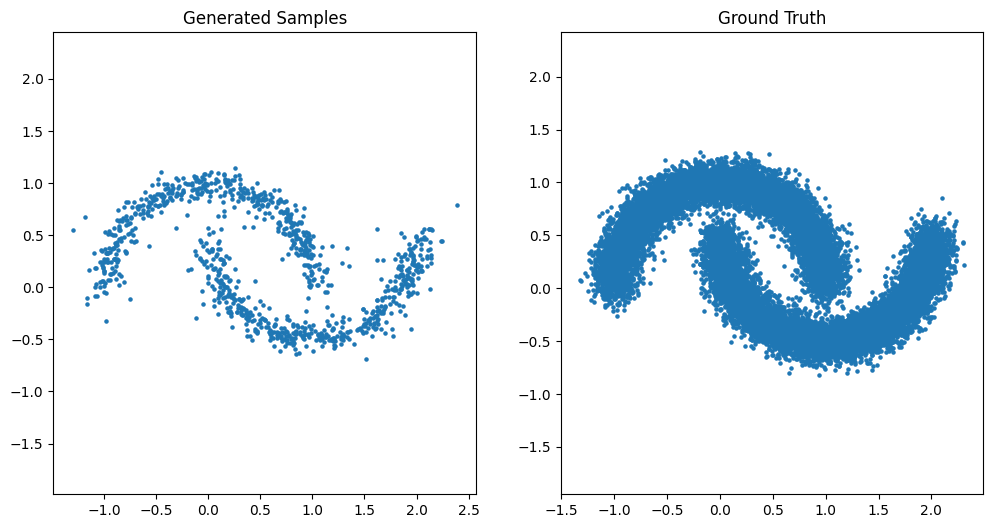

Distance: 0.5410
MSE: 0.0111


In [45]:
ev = Evaluator(trainer, num_samples=1000)
ev.eval()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


class Evaluator:
    def __init__(self, trainer, num_samples=100):
        self.trainer = trainer
        self.diffusion = trainer.diffusion

        self.num_samples = num_samples

    def eval(self):
        with torch.no_grad():
            samples = self.diffusion.sample(self.num_samples).cpu()

        self._visualize(samples)

        metrics = self.calculate_metrics(samples)
        print(f"Distance: {metrics['distance']:.4f}")
        print(f"MSE: {metrics['mse']:.4f}")

    def calculate_metrics(self, generated_samples):
        real_samples = (
            trainer.train_dataset[: len(generated_samples)].clone().cpu().numpy()
        )
        generated_samples = generated_samples.numpy()

        return {
            "distance": self.calculate_distance_metric(generated_samples, real_samples),
            "mse": self.calculate_mse_metric(generated_samples, real_samples),
        }

    def calculate_shape_metric(self, generated_samples, real_samples):
        kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
        labels = kmeans.fit_predict(generated_samples)

        unique_labels = np.unique(labels)
        if len(unique_labels) < 2:
            return 1.0

        silhouette = silhouette_score(samples, labels)
        return (1.0 - silhouette) / 2.0

    def calculate_mse_metric(self, generated_samples, real_samples):
        all_samples = np.vstack([real_samples, generated_samples])
        x_min, x_max = all_samples[:, 0].min() - 0.5, all_samples[:, 0].max() + 0.5
        y_min, y_max = all_samples[:, 1].min() - 0.5, all_samples[:, 1].max() + 0.5
        bounds = [[x_min, x_max], [y_min, y_max]]

        real_hist, _, _ = np.histogram2d(
            real_samples[:, 0], real_samples[:, 1], bins=64, range=bounds
        )
        gen_hist, _, _ = np.histogram2d(
            generated_samples[:, 0], generated_samples[:, 1], bins=64, range=bounds
        )

        real_hist = real_hist / real_hist.max() if real_hist.max() > 0 else real_hist
        gen_hist = gen_hist / gen_hist.max() if gen_hist.max() > 0 else gen_hist

        return np.mean((real_hist - gen_hist) ** 2)

    def calculate_distance_metric(self, generated_samples, real_samples, radius=0.02):
        nn = NearestNeighbors(n_neighbors=1).fit(real_samples)
        distances, _ = nn.kneighbors(generated_samples)

        return 1.0 - (distances.flatten() < radius).astype(int).sum() / len(
            generated_samples
        )

    def _visualize(self, samples):
        gt = self.trainer.train_dataset.clone().cpu()

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.title("Generated Samples")
        plt.scatter(samples[:, 0], samples[:, 1], s=5)
        plt.axis("equal")

        plt.subplot(1, 2, 2)
        plt.title("Ground Truth")
        plt.scatter(gt[:, 0], gt[:, 1], s=5)
        plt.axis("equal")

        plt.show()